# Recommender System for Recipes

TODO for FINAL-FINAL-Version:
- Evaluation Test Set (Hybrid Model against Baseline Model with all metrics incl. RMSE) - Prio 1
- <s>Schönheitsfehler im Code - Prio 3 DONE
    Imports strukturieren (+ alle nach oben) DONE
    Kommentare DONE
    Output in Console DONE
    Kapitel-Nummerierung: 1.1 vs. 2.0 & Hybrid Modell Kapitel in ToC einfügen DONE</s>
- Tabelle zum Hybrid Model: Weights -> Evaluation Measures (Classification Metric Tabelle) - Prio 1
- <s>Fehler in Auswahl des besten KNNModells (KNNwithMeans anstatt KNNBaseline) - Prio 1 DONE</s>
- <s>Description bei Content-based rausnehmen, da RMSE verschlechtert - Prio 2 DONE</s>
- <s>Information am Anfang "Functions with minor relevance"- Prio 3 DONE</s>
- RMSE zu Plain Cosine berechnen - Prio 1/2
- Kommentare zu Fit the Model -> hinweis, dass bei Evaluation gefittet wird - Prio 3
- Hard Coded Backup der Hyperparameter überarbeiten - Prio 3

## Table of Contents
[1. Data Preprocessing and Imports](#preprocessing) <br>
    [1.1. Recipe filter/sampler](#filter_recipes) <br>
    [1.2. User filter/sampler](#filter_users) <br>
    [1.3. Interaction filter/sampler](#filter_interactions) <br>
    [1.4. NLP Preprocessing](#nlp-preprocessing) <br>
    [1.5. Preprocessing Summary](#summary_preprocessing) <br>
    
[2. Train/Test Split](#train_test_split) <br>

[3. Models](#models) <br>
    [3.1. General functions](#general-functions) <br>
        [3.1.1. Recommendations functions for Coverage & Personalization](#recommendation-functions) <br>
        [3.1.2. Prediction function for RMSE](#prediction-functions) <br>
    [3.2 Content-Based Models](#content-based) <br>
    [3.2.1 Cosine Similarity](#cosine) <br>
        [3.2.1.1 Tfidf & SVD](#tfidf-svd) <br>
        [3.2.1.2 WordEmbeddings](#word-embeddings) <br>
    [3.2.2 Mixture Model](#mixture) <br>
    [3.3 Collaborative Filtering Models](#collab_filt) <br>
    [3.3 Hybrid Model](#hybrid_model) <br>
    
[4. Interpretation and Evaluation](#evaluation) <br>
    [4.1 Single Algorithms Classification Metrics](#single_algos) <br>
    [4.2 Final Scores](#final_scores) <br>
    [4.3 Recommendations](#get_recommendations) <br>

<a id='preprocessing'></a>
## 0. Imports

##### Packages to install in cmd upfront:

conda install -c conda-forge selenium <br>
conda install -c anaconda nltk <br>
conda install -c conda-forge progressbar <br>
conda install -c conda-forge scikit-surprise

In [69]:
import pandas as pd
import numpy as np
import nltk
import inflect
import datetime
import time
import re, string, unicodedata
import progressbar
import collections
import itertools
from collections import defaultdict
import matplotlib.pyplot as plt
from IPython.display import HTML
from datetime import datetime, timedelta
from progressbar import ProgressBar
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk import SnowballStemmer
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec 
from sklearn.metrics import jaccard_score, pairwise_distances_chunked, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
from surprise import SVD, NMF, KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, NormalPredictor, BaselineOnly, CoClustering, SlopeOne
from surprise import Dataset, Reader, accuracy, Trainset
from surprise.model_selection import cross_validate, GridSearchCV, ShuffleSplit
import gensim.downloader as api

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Bene\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Bene\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Bene\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Import functions module (Includes Preprocessing and Evaluation functionalities)
%run functions.py
pd.set_option('display.max_colwidth', -1)

## 1. Preprocessing

In [3]:
#load data
interactions_raw = pd.read_csv('Data/RAW_interactions.csv')
recipes_raw = pd.read_csv('Data/RAW_recipes.csv', parse_dates=['submitted'], infer_datetime_format=True)

In [4]:
#make copies so that we don't have to reload the data after mistakes
interactions_data = interactions_raw.copy()
recipes_data = recipes_raw.copy()

In [5]:
# Rename column in recipe data frame to have matching column names for the recipe id between recipe dataframe and
# interaction data frame
recipes_data.rename(columns={"id": "recipe_id"}, inplace=True)

In [6]:
# Deal with missing values and errors in data set
# - Drop recipes without title
# - Replace missing descriptions with empty string
# - Replace missing minutes of a recipe if those can be found in the text
# - Drop fake recipes (e.g. "How to preserve a husband")
deal_with_NAs(recipes_data)

<a id='filter_recipes'></a>
### 1.1. Filter recipes

In [7]:
# Filter the recipes (filtering is carried out inplace)

# Add age and average rating required for filtering
recipes_data['age'] = round((2019-recipes_data.submitted.dt.year)+recipes_data.submitted.dt.month/12, 1)
recipes_data = get_avg_recipe_rating(interactions_data, recipes_data)
# Filter based on number of interactions
# Recipes older than 10 years need to have at least ten ratings
filter_byinteractions(10,10,recipes_data, older=True)
# Recipes younger than ten years need to have at least 5 ratings
filter_byinteractions(5,10,recipes_data, older=False)
# Filter based on qualitative criteria
filter_byquality(recipes_data)
# Remove recipes that have the same title
remove_duplicates(recipes_data)
# Generate the URL to the foods.com website for remaining recipes
recipes_data = generate_URL(recipes_data)

Shape after filtering recipes with less than 10 interactions and older than 10 years old: (48605, 15)
Shape after filtering recipes with less than 5 interactions and younger than 10 years old: (20487, 15)
Shape after removing 1 step recipes w/ low interactions: (20487, 15)
Shape after removing recipes w/o ratings: (20487, 15)
Shape after removing 0 minutes interaction w/ low interactions: (20397, 15)
Shape after dropping duplicates: (20371, 15)
URLs created for each of the 20371 recipes


In [8]:
recipes_data.shape

(20371, 16)

<a id='filter_users'></a>
### 1.2 Filter users

Filter data flow:

filter_interactions_data() -(calls)-> 
    (impute_average_rating(), (create_activity_data() 
                                        -(calls)-> get_user_activity_df())

In [9]:
def impute_average_rating(row, df_uactivity):
    if (row['rating'] == 0):
        imputed_rating = round(df_uactivity.loc[df_uactivity.user_id == row.user_id, 'uavg_rating'].values[0], 0)
        return imputed_rating
    else:
        return row.rating
    
def get_user_activity_df(interactions):
    #Create a user activity dataframe
    df_uactivity = interactions.groupby('user_id')['rating'].value_counts().unstack().fillna(0)
    cols = list(df_uactivity)
    df_uactivity['total_interactions'] = df_uactivity[cols].sum(axis=1)
    df_uactivity['total_ratings'] = df_uactivity['total_interactions']-df_uactivity[0]
    return df_uactivity

def get_user_behavior(filtered_user_activity):
    #calculate arithmetic mean of ratings for each user
    filtered_user_activity['uavg_rating'] = filtered_user_activity.iloc[:,1:6].apply(
        lambda row: np.round(np.ma.average(list(range(1,6)), 
                                           weights = (row[1], row[2], row[3], row[4], row[5])),1), axis = 1)
    filtered_user_activity = filtered_user_activity.reset_index()
    filtered_user_activity.columns.set_names(None, inplace = True)
    return filtered_user_activity
    
def filter_users(interactions_df, thresh_high, thresh_low):
    df_uactivity = get_user_activity_df(interactions_df[['recipe_id','user_id', 'rating']])
    filtered_user_activity = df_uactivity.loc[(df_uactivity['total_interactions']>=thresh_low) &
                                              (df_uactivity['total_interactions']<thresh_high), :]
    
    print(f'Number of users after filtering out users with less than {thresh_low} interactions: {len(filtered_user_activity)}')
    
    #drop users that only have only reviews but no ratings
    filtered_user_activity.drop(filtered_user_activity[filtered_user_activity.total_ratings == 0].index, 
                                inplace=True, 
                                axis=0)
    
    #create average user ratings as behavior
    filtered_user_activity = get_user_behavior(filtered_user_activity)
    
    return filtered_user_activity

def filter_interactions_data(interactions_df, recipes_data, thresh_high, thresh_low):
    
    # 2. Filter interactions with active recipes -> Only interactions from active users and clean recipes remain
    interactions = interactions_df[interactions_df.recipe_id.isin(recipes_data.recipe_id)]
    
    filtered_user_activity = filter_users(interactions, thresh_high, thresh_low)
    # 1. Get user ids of active
    interactions = pd.merge(filtered_user_activity[['user_id', 'uavg_rating', 'total_interactions']], 
                                        interactions[['recipe_id','user_id', 'rating']], 
                                        how = 'left', on ='user_id')
    
    #impute ratings for interactions without ratings
    zero_ratings = len(interactions.loc[interactions.rating==0])
    interactions['rating'] = interactions.apply(lambda row: impute_average_rating(row, filtered_user_activity), axis=1)
    print(f'Number of imputed ratings: {zero_ratings}')

    return interactions[['user_id','recipe_id','rating','uavg_rating', 'total_interactions',]], filtered_user_activity

<a id='filter_interactions'></a>
### 1.3 Fiiter interactions

In [10]:
# Filter interactions data such that only interaction with active users (at least 7 ratings, but not more than 100) 
# and with recipes that were not filtered out before remain
interactions, activity = filter_interactions_data(interactions_data, recipes_data, thresh_high=100, thresh_low=9)
display(interactions.head())
print(interactions.shape)

Number of users after filtering out users with less than 9 interactions: 8436
Number of imputed ratings: 5709


,user_id,recipe_id,rating,uavg_rating,total_interactions
0,1533,96621,5.0,4.8,32.0
1,1533,2137,5.0,4.8,32.0
2,1533,132916,5.0,4.8,32.0
3,1533,13813,5.0,4.8,32.0
4,1533,57549,5.0,4.8,32.0


(204223, 5)


count    8431.000000
mean     23.545724  
std      18.353140  
min      2.000000   
25%      11.000000  
50%      16.000000  
75%      29.000000  
max      99.000000  
Name: total_ratings, dtype: float64


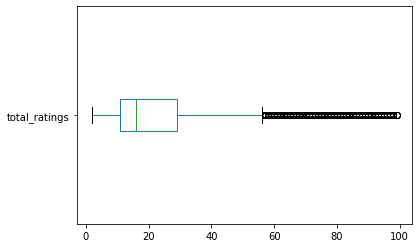

In [11]:
# Check the distribution of number of ratings per user, to validate the upper limit of ratings for filtering the users
activity['total_ratings'].plot(kind='box', vert=False)
print(activity.total_ratings.describe())

Percent of 5 star rating interactions: 79.22%
Percent of 4 star rating interactions: 15.36%
Percent of 3 star rating interactions: 3.6%
Percent of 2 star rating interactions: 1.23%
Percent of 1 star rating interactions: 0.59%


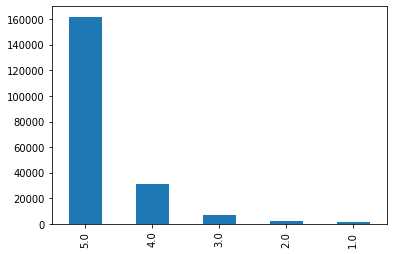

In [12]:
#Let's look at the distribution of ratings
get_rating_dist(interactions.rating)

<a id='nlp-preprocessing'></a>
### 1.4. Preprocessing for recipe data

In [13]:
# Function to concatenate the textual data per recipe to one string used for the content based approach
def create_input (df, column_names):
    df_content = df
    df_content = df_content.assign(content= df.loc[:, (column_names)].apply(lambda texts: ' '.join(texts), axis=1))
    df_content = df_content.drop(columns = column_names)
    df_content['content']=df_content['content'].apply(lambda text: ' '.join(text.split()))
    return df_content

In [14]:
# Flatten recipe´s steps
content_processed = recipes_data.copy()
content_processed.steps = content_processed.loc[:, ('steps')].str.replace("\[", "").str.replace("'", "").str.replace("\]", "").str.replace(",","").copy()

# Concatenate recipe name and steps to one string per recipe -> name and steps are most meaningful (steps most likely also include ingredients)
content_processed = create_input(content_processed[['recipe_id', 'name', 'steps']], ['name', 'steps'])

content_processed.head()

,recipe_id,content
15,63986,chicken lickin good pork chops dredge pork chops in mixture of flour salt dry mustard and garlic powder brown in oil in a large skillet place browned pork chops in a crock pot add the can of soup undiluted cover and cook on low for 6-8 hours
17,23933,chinese candy melt butterscotch chips in heavy saucepan over low heat fold in peanuts and chinese noodles until coated drop by tablespoon onto waxed paper let stand in cool place until firm
33,54100,grilled venison burgers in bowl mix dry ingredients add venison and mix well add liquid ingredients and mix well with a fork until bread crumbs are barely noticeable on plastic wrap form into 8 patties making them round and very flat-- like a fast-food burger they can be cooked immediately but i prefer to freeze them first place them on a large cookie sheet and freeze them several hours remove from freezer and place waxed paper between each burger as you stack them i stack them in 2 1-quart freezer zip-lock bags preheat cast iron skillet to very hot cook frozen burgers until they are slightly charred on one side and then turn and cook until the other side is slightly charred and burgers are medium-well do not overcook turn burner off and leave burgers in the pan while you put condiments on your hamburger bun if cooking thawed burgers cook about 2-3 minutes per side
34,67664,healthy for them yogurt popsicles mix all the ingredients using a blender pour into popsicle molds freeze and enjoy !
36,25775,how i got my family to eat spinach spinach casserole preheat oven to 350 degrees place spinach in strainer and squeeze all extra liquid from it in a large bowl combine spinach with the rest of ingredients except croutons and combine well pour into a 2 quart casserole dish and top with croutons bake for 35 to 40 minutes or until bubbling around edges


In [15]:
# Run NLP-preprocessing on the recipe content
content_processed = get_processed(content_processed)
content_processed.shape

(20371, 2)

<a id='summary_preprocessing'></a>
### 1.5 Remaining data size (Summary)

In [96]:
n_recipes = len(content_processed)
n_users = len(interactions.user_id.unique())
print(f'Number of recipes: {n_recipes}')
print(f'Number of users: {n_users}')
print(f'Number of interactions: {len(interactions)}')

# Free some memory
del interactions_raw, recipes_raw, interactions_data

Number of recipes: 20371
Number of users: 8431
Number of interactions: 204223


<a id='train_test_split'></a>
## 2. Train-Test-Split

In [17]:
def get_fixedN_test_train_split(interactions, n):
    """
    Parameters
    ---------
    
    Returns
    ---------
    test_split: DataFrame
        Interactions DataFrame containing only n interactions per user
    train_split: DataFrame
        Interactions DataFrame containing the rest of the interactions
    """
    
    test_split = pd.DataFrame(columns = ['user_id', 'recipe_id', 'rating'])
    groups = interactions.groupby('user_id')
    
    #with progressbar.ProgressBar(max_value=len(interactions.user_id.drop_duplicates().values)) as bar:
    for i, group in groups:
        test_shard = group.sample(n=n, random_state=10)
        test_split = pd.concat([test_split, test_shard], ignore_index=True)
            
    interactions = interactions.set_index(['user_id', 'recipe_id']).sort_index()    
    test_split = test_split.set_index(['user_id', 'recipe_id']).sort_index()
    train_split = interactions[~interactions.index.isin(test_split.index)]
    
    train_split.reset_index(inplace=True)
    test_split.reset_index(inplace=True)
    
    
    return train_split, test_split

In [18]:
#Create train-test split of interaction data by keeping a fixed number of interactions per user for testing
fixed_n_test = 3
train_split, test_split = get_fixedN_test_train_split(interactions, fixed_n_test)

Test size: 14.14% 

Rating distribution in test set 

Percent of 5 star rating interactions: 79.6%
Percent of 4 star rating interactions: 14.72%
Percent of 3 star rating interactions: 3.61%
Percent of 2 star rating interactions: 1.41%
Percent of 1 star rating interactions: 0.66%


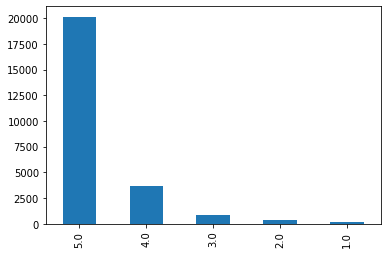

In [19]:
# Validate quality of train-test split
print(f'Test size: {round((len(test_split)/len(train_split)) * 100,2)}% \n')
print('Rating distribution in test set \n')
get_rating_dist(test_split.rating)

<a id='models'></a>
## 3. Models

<a id='general-functions'></a>
###  General functions

<a id='recommendation-functions'></a>
#### Recommendations functions for precision

In [20]:
#return top k predicted ratings in readable form 

# IMPORTANT: must set the dataframe for recipe_info index == recipe_id!
def get_user_recommendations(user_id, similarity, content, interactions, recipe_info, k):
    """
     Returns
    ----------
    info:
        HTML dataframe with recommendation information
    """
    #get top k recipe ids
    topk_recipes, predictions, recipeurls, imageurls = get_topk_recipes(user_id, similarity, content, interactions, k)
    info = recipe_info.loc[topk_recipes]
    info = info[['name', 'minutes', 'submitted', 'description']]
    info['prediction'] = predictions
    info['recipeurl'] = recipeurls
    info['imageurl'] = imageurls
    for index, row in info.iterrows():
        info.at[index, 'recipeurl'] = '<a href="'+ row['recipeurl'] + '">'+ row['recipeurl'] + '</a>'
        info.at[index, 'imageurl'] = '<a href="'+ row['imageurl'] + '"> Image of recipe '+ str(index) + '</a>'
    info = HTML(info.to_html(escape=False))
    return info

def get_topk_recipes(user_id, similarity, content, interactions, k):
    """
     Returns
    ----------
    topk_recipes:
        array of top k recipe ids
    predictions:
        array with top k predictions
    recipeurls:
        array with top k recipe urls
    imageurls:
        array with top k recipe imageurls
    """
    prediction_df = get_user_preference(user_id,similarity, content, interactions)
    #take only the not yet seen recipes
    #new_predictions = prediction_df[prediction_df['has_rated'] == False]
    #sort predictions
    ordered_predictions = new_predictions.sort_values(by='prediction', ascending=False)
    #get recipe_id array
    topk_recipes = ordered_predictions.index[:k].values
    imageurls = []
    recipeurls = []
    for entry in topk_recipes:
        recipeurls.append("https://www.food.com/recipe/" + str(entry))
        imageurls.append(get_image_source_url(entry))
    predictions = ordered_predictions.prediction[:k].values
    return topk_recipes, predictions, recipeurls, imageurls

#return predictions for 1 user
def get_user_preference(user_id, similarity, content, interactions_data):
    """
     Returns
    ----------
    prediction_df:
        DataFrame in with columns ['recipe_id','prediction', 'has_rated'] for 1 user
    """
    #prepare similarity dataframe
    sim = pd.DataFrame(similarity, index = content['recipe_id'].values, columns = content['recipe_id'].values)
    #get already rated recipes of user
    rated_recipes = interactions_data.loc[interactions_data['user_id'] == user_id, 'recipe_id'].values
    #get similarities of ALL recipes w/ already rated recipes of user
    sim_rated_all = sim.loc[rated_recipes, :]
    #get ratings of already rated recipes
    ratings = get_reshaped_ratings(user_id, interactions_data)
    
    #compute weighted similarities between all recipes and already rated recipes
    weighted_sim = np.dot(ratings,sim_rated_all)
    #compute normalization constant
    norm_const = np.array(np.abs(sim_rated_all).sum(axis=0))
    #return sorted predictions
    pref_predictions = weighted_sim/norm_const
    
    flat_predictions = [item for sublist in pref_predictions for item in sublist]
    #return df with recipe id also
    prediction_df = pd.DataFrame(flat_predictions, index = content['recipe_id'].values, columns = ['prediction'])
    #indicate the already tried recipes
    prediction_df['has_rated'] = prediction_df.index.isin(rated_recipes)
    #order predictions
    return prediction_df

#arrange ratings for matrix multiplication
def get_reshaped_ratings(user_id, interactions_data):
    ratings = interactions_data.loc[interactions_data['user_id'] == user_id, :]
    ratings.set_index('recipe_id', inplace=True)
    ratings.index.set_names(None, inplace = True)
    ratings = ratings.drop(columns = 'user_id')
    ratings = ratings.transpose()
    ratings.rename(index={'rating':user_id}, inplace=True)
    return ratings.loc[ratings.index == user_id]

In [21]:
def make_all_recommendations(user_ids, similarity, content, interactions, k):
    """
    Params
    --------
    user_ids: Array
        list of user ids
    similarity: Array 
        similarity matrix with shape (#recipes, #recipes).
    content: DataFrame
        processed DataFrame with ['recipe_id', 'content'] used to fetch all recipes ids to make recommendations for 
        (=total training data)
    interactions: DataFrame
        preprocessed interactions DataFrame ['recipe_id', 'user_id', 'rating']     
    k: integer
        number of recommendations to make
    Returns:
    --------
    nested_recommendations:
        nested list of recommended recipe_ids for each user in param list
        example:[[rid1, rid20, rid30...], [rid1, rid20, rid30...],[rid1, rid20, rid30...]]
    """
    pbar = ProgressBar()
    nested_recommendations = {}
    for i in pbar(range(len(user_ids))):
        recs = get_topk_recipes_lean(user_ids[i], similarity, content, interactions, k)
        nested_recommendations[user_ids[i]] = recs
    return nested_recommendations

def get_topk_recipes_lean(user_id, similarity, content, interactions, k):
    """
     Returns
    ----------
    topk_recipes:
        array of top k recipe ids
    predictions:
        array with top k predictions
    recipeurls:
        array with top k recipe urls
    imageurls:
        array with top k recipe imageurls
    """
    prediction_df = get_user_preference(user_id, similarity, content, interactions)
    #filter the already rated recipes (we do not recommend those)
    prediction_df = prediction_df.loc[prediction_df.has_rated == False]
    #sort predictions
    ordered_predictions = prediction_df.sort_values(by='prediction', ascending=False)
    #get recipe_id array
    topk_recipes = ordered_predictions.index[:k].tolist()
    predictions = ordered_predictions.prediction[:k].tolist()
    return topk_recipes

<a id='prediction-functions'></a>
#### Prediction function for RMSE

In [22]:
#prediction for 1 already rated recipe based on similarities to other already rated recipes
def get_one_prediction(similarity, content, interactions, user_id, recipe_id):
    sim = pd.DataFrame(similarity, index=content['recipe_id'].values, columns=content['recipe_id'].values)
    #get already rated recipes of user
    rated_recipes = interactions[(interactions['user_id']==user_id) & (interactions['recipe_id']!=recipe_id)]['recipe_id'].values
    #get similarities of to be predicted recipe rating with already rated recipes by user x
    sim_rated = sim.loc[sim.index==recipe_id, rated_recipes].loc[recipe_id].values
    #get ratings of rated recipes
    ratings = interactions[(interactions['user_id']==user_id) & (interactions['recipe_id']!=recipe_id)]['rating'].values
    
    actual = interactions.loc[(interactions.user_id==user_id) & (interactions.recipe_id==recipe_id)]['rating'].values[0]
    prediction = np.dot(ratings, sim_rated)/np.array([np.abs(sim_rated).sum(axis=0)])
    return actual, prediction

# Calls get_one_prediction for all users and recipes
def make_all_predictions(num_interactions, similarity, content, interactions, uid_array, rids_array):
    predictions_cos = []
    actual_cos = []
    mean_rating = interactions.rating.mean()
    pbar = ProgressBar()
    
    for i in pbar(range(num_interactions)):
        act, pred = get_one_prediction(similarity, content, interactions, uid_array[i], rids_array[i])
        
        if(np.isnan(pred[0])):
            pred = mean_rating
        
        predictions_cos.append(pred)
        actual_cos.append(act)
        
    return predictions_cos, actual_cos

<a id='content_based'></a>
### 3.2 Content-Based Models

<a id='cosine'></a>
### 3.2.1 Cosine similarity

<a id='tfidf-svd'></a>
#### 3.2.1.1 TFIDF/SVD

In [23]:
def get_cos_sim_matrix(processed, n_components = 10, use_svd = True):
    '''
    Compute the cosine similarity matrix based on TF-IDF and SVD truncation
    '''
    tfidf = TfidfVectorizer(stop_words = 'english')
    processed['content'] = processed['content'].fillna('')
    tfidf_matrix = tfidf.fit_transform(processed['content'])
    if use_svd:
        #reduce dimensionality of tfidf matrix
        svd = TruncatedSVD(n_components = n_components, random_state = 42)
        tfidf_truncated = svd.fit_transform(tfidf_matrix)
    else:
        tfidf_truncated = tfidf_matrix
    cosine_sim = cosine_similarity(tfidf_truncated, tfidf_truncated)
    return cosine_sim

#### Hyperparameter Tuning

In [24]:
def tuning_cos_rmse(n_components, content, interactions, uid_array, rids_array):
    '''
    Function computes the RMSE for different number of components for the used SVD
    '''
    rmse_cos = []
    
    for n in n_components:
        print("Computing predictions & recommendations for:", n)
        similarity = get_cos_sim_matrix(content, n)
        
        predictions, actuals = make_all_predictions(len(interactions), 
                                                    similarity, 
                                                    content, 
                                                    interactions, 
                                                    uid_array, 
                                                    rids_array)
        rmse = mean_squared_error(actuals, predictions)**0.5
        print(n, '=n_components', 'rmse:', rmse)
        rmse_cos.append(rmse)
        
           
    return rmse_cos

In [25]:
# Define a suitable parameter range for the components of the SVD
n_components = [5, 50, 100, 200]
# Tune the actual hyperparameters
rmse_cos_tune = tuning_cos_rmse(n_components,
                               content_processed,
                               train_split,
                               train_split['user_id'].values,
                               train_split['recipe_id'].values, 
                               )
# Get the hyperparameter with the lowest RMSE on the dev set
rmse_cos_tune_min = min(rmse_cos_tune)
rmse_cos_tune_min_idx = rmse_cos_tune.index(rmse_cos_tune_min)
n_components_min = n_components[rmse_cos_tune_min_idx]

Computing predictions & recommendations for: 50


100% |########################################################################|


50 =n_components rmse: 0.6251727049432936
Computing predictions & recommendations for: 100


100% |########################################################################|


100 =n_components rmse: 0.6285713966150335
Computing predictions & recommendations for: 200


100% |########################################################################|


200 =n_components rmse: 0.627804843673034


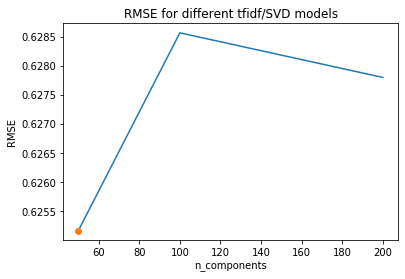

In [26]:
# Plot the RMSE for different numbers of components
plt.plot(n_components, rmse_cos_tune)
plt.xlabel('n_components')
plt.ylabel('RMSE')
plt.title('RMSE for different tfidf/SVD models')
plt.plot([n_components_min], [rmse_cos_tune_min], 'o')
plt.show()

In [132]:
n_components_min

50

In [41]:
rmse_cos_tune_min

0.6251727049432936

In [84]:
# RMSE for plain cosine
predictions, actuals = make_all_predictions(len(train_split), 
                                            get_cos_sim_matrix(content_processed, n_components_min, use_svd=False), 
                                            content_processed, 
                                            train_split, 
                                            train_split['user_id'].values,
                                            train_split['recipe_id'].values, )
rmse_cosine_plain = mean_squared_error(actuals, predictions)**0.5
rmse_cosine_plain

100% |########################################################################|


0.6206882826590207

#### Fit the models

In [27]:
# Proximity matrix of the TFIDF-SVD model
# similarity_matrix_svd = get_cos_sim_matrix(content_processed, n_components_min, use_svd=True)

In [28]:
# Proximity matrix for the plain TFIDF model
# similarity_matrix = get_cos_sim_matrix(content_processed, n_components_min, use_svd=False)

<a id='word-embeddings'></a>
#### 3.2.1.2. WordEmbeddings

#### Proximity Matrix

In [29]:
def normalize_tfidf(tfidf_vector, weights):
    '''
    Function computes the weighted average of a tf-idf vector
    '''    
    return(np.average(tfidf_vector, weights = weights, axis = 0))

def get_tfidf_wordembedding_matrix(content_separated, vocabulary_name):
    '''
    Function generates word embedding matrix from pre-trained vocabulary and the recipe content separated by spaces
    '''
    # Load pre-trained vocabulary
    model = api.load(vocabulary_name) # glove-wiki-gigaword-100 glove-wiki-gigaword-200 glove-wiki-gigaword-300
    word2vector = dict(zip(model.wv.index2word, model.wv.vectors))

    # Compute tf-idf vector
    tfidf = TfidfVectorizer(analyzer=lambda x: x)
    tfidf.fit(content_separated)

    # create dictionary with all vocabulary items and their tf-idf distance
    max_idf = max(tfidf.idf_)
    word2word = collections.defaultdict(
        lambda: max_idf,
        [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

    # get representation of contents as tf-idf (second dimension used for weights)
    dim = len(word2vector.items())
    tfidf_matrix = np.array([
        normalize_tfidf([word2vector[w] * word2word[w] for w in words if w in word2vector]
                        or [np.zeros(dim)], [word2word[w] for w in words if w in word2vector or 0])
        for words in content_separated
    ])
    
    return tfidf_matrix

#### Hyperparameter Tuning

In [30]:
def tuning_emb_vocab_size(vocabulary_names, content, content_seperated, interactions, uid_array, rids_array):
    '''
    Function tune size of vocabulary by trying out different vocabularies
    '''
    rmse_emb = []
    
    for vocabulary_name in vocabulary_names:
        tfidf_matrix = get_tfidf_wordembedding_matrix(content_seperated, vocabulary_name)
        similarity = cosine_similarity(tfidf_matrix, tfidf_matrix)
        
        predictions, actuals = make_all_predictions(len(interactions), similarity, content, interactions, uid_array, rids_array)
        rmse = mean_squared_error(actuals, predictions)**0.5
        rmse_emb.append(rmse)

    return rmse_emb

In [31]:
# Parameter space for the word embedding model, parameters represent size of embedding
vocabulary_names = ["glove-wiki-gigaword-50", "glove-wiki-gigaword-100", "glove-wiki-gigaword-200", "glove-wiki-gigaword-300"]
# Tokenized content required to tune the parameters
content_tokenized = [content_item.split(" ") for content_item in content_processed["content"]]
# Choose the size with the smallest RMSE on the dev set
rmse_emb_tune = tuning_emb_vocab_size(vocabulary_names,
                                      content_processed,
                                      content_tokenized,
                                      train_split,
                                      train_split['user_id'].values,
                                      train_split['recipe_id'].values)
rmse_emb_min = min(rmse_emb_tune)
rmse_emb_min_idx = rmse_emb_tune.index(rmse_emb_min)
vocabulary_name_min = vocabulary_names[rmse_emb_min_idx]

100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


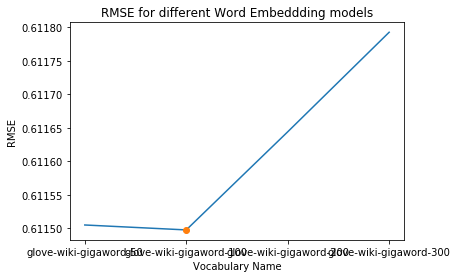

In [32]:
# Plot the RMSE for different sizes of word embeddings
plt.plot(vocabulary_names, rmse_emb_tune)
plt.xlabel('Vocabulary Name')
plt.ylabel('RMSE')
plt.title('RMSE for different Word Embeddding models')
plt.plot([vocabulary_name_min], [rmse_emb_min], 'o')
plt.show()

In [133]:
vocabulary_name_min

'glove-wiki-gigaword-100'

In [40]:
rmse_emb_min

0.6114978406272078

#### Fit the model

In [33]:
# Proximity matrix of the embedded model
# tfidf_matrix = get_tfidf_wordembedding_matrix(content_tokenized, vocabulary_name_min)
# similarity_matrix_embedded = cosine_similarity(tfidf_matrix, tfidf_matrix)

<a id='mixture'></a>
### 3.2.2 Mixture Model

#### Proximity Matrix

In [34]:
def get_mix_sim_matrix(processed, lmbda, df_rfiltered):
    '''
    Function to compute proximity matrix for the mixture model
    '''
    cos_sim = get_cos_sim_matrix(processed, n_components_min, False)
    df_sub = df_rfiltered[['recipe_id', 'n_steps', 'minutes', 'n_ingredients']]
    df_processed = df_sub[df_sub['recipe_id'].isin(processed['recipe_id'])]\
                                                             .set_index('recipe_id')
    scaler = StandardScaler()
    X = scaler.fit_transform(df_processed)
    eucl_dis = euclidean_distances(X,X)
    eucl_sim = 1 / np.exp(eucl_dis)
    mixed_sim = np.add(cos_sim * lmbda, eucl_sim * (1-lmbda)) # assume equally weighted
    return mixed_sim

<a id='optimize-lambda'></a>
#### Hyperparamter Tuning

In [35]:
def tuning_mix_param(lmbdas, content, df_rfiltered, interactions, uid_array, rids_array):
    '''
    Function computes the RMSE for different sizes of lambda (weighting parameter of the mixture model)
    '''
    rmse_mix = []
    
    for lmbda in lmbdas:
        similarity = get_mix_sim_matrix(content, lmbda, df_rfiltered)
        
        predictions, actuals = make_all_predictions(len(interactions), 
                                                    similarity, 
                                                    content, interactions, 
                                                    uid_array, 
                                                    rids_array)
        rmse = mean_squared_error(actuals, predictions)**0.5
        rmse_mix.append(rmse)
           
    return rmse_mix

In [36]:
# Set a suitable parameter range for lambda
lmbdas = np.linspace(0,1,5)
# Compute the RMSE for different lambdas (weighting paramtere)
rmse_mix_tune = tuning_mix_param(lmbdas, 
                                 content_processed,
                                 recipes_data,
                                 train_split, 
                                 train_split['user_id'].values, 
                                 train_split['recipe_id'].values)
rmse_mix_min = min(rmse_mix_tune)
rmse_mix_min_idx = rmse_mix_tune.index(rmse_mix_min)
lmbda_min = lmbdas[rmse_mix_min_idx]

100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


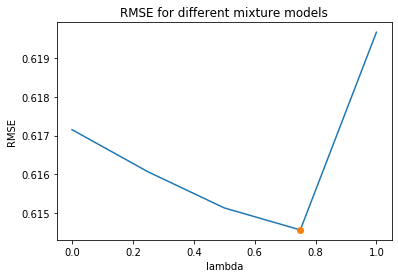

In [37]:
# Plot the RMSE for different sizes of lambda
plt.plot(lmbdas, rmse_mix_tune)
plt.xlabel('lambda')
plt.ylabel('RMSE')
plt.title('RMSE for different mixture models')
plt.plot([lmbda_min], [rmse_mix_min], 'o')
plt.show()

In [131]:
lmbda_min

0.75

In [39]:
rmse_mix_min

0.6145580467884502

#### Fit the model

In [ ]:
# Proximity matrix of the mixture model
# similarity_matrix_mixed = get_mix_sim_matrix(content_processed, lmbda_min, recipes_data)

<a id='collab_filt'></a>
### 3.3 Collaborative Filtering Models

In [42]:
def create_pivot_table(pd_df):
    '''
    Function computes creates Pivot Matrix from dataframe
    '''    
    data = pd_df.values
    rows, row_pos = np.unique(data[:, 0], return_inverse=True) #Retrieves sorted array of unqiue values of pd_df and the corresponding inverse in order to reconstruct the original array
    cols, col_pos = np.unique(data[:, 1], return_inverse=True) #Retrieves sorted array of unqiue values of pd_df and the corresponding inverse in order to reconstruct the original array
    pivot_matrix = np.zeros((len(rows), len(cols)), dtype=data.dtype)
    pivot_matrix[row_pos, col_pos] = data[:, 2] #Matrix is column wise filled by the original positions of movieId and userId
    return pivot_matrix

In [54]:
def make_all_recommendations_cf(algo, trainset, neighbors, data_set, recipe_ids, k, return_est_ratings=False):
    """
    Function returns either a dict of users in which the values are lists of the recommended recipes or lists of ratings
    for all recipes, depending on the parameter return_est_ratings
    
    Params
    --------
    algo: Suprise Package Algorithm
        A algorithm of the suprise package
    trainset: Trainset
        The suprise package trainset the algorithm was trained on
    neighbors: int
        The number of neighbors use for the algorithm in case it is KNN-inspired
    data_set: pd.DataFrame
        Our train split on which the models are trained
    recipe_ids: list
        All recipe ids we need predicitions for (usually the unique recipe ids from train and dev set)
    k: integer
        Number of recommendations to make, only considered if return_est_ratings is false
    return_est_ratings: bool
        Flag whether the top k list per user or all estimated recipe ratings per user should be returned
    Returns:
    --------
    """
    start = time.time()

    # Get the number of users and number of recipes
    n_users = len(data_set.user_id.unique())
    n_recipes = len(recipe_ids)
    
    # Get users we need a predicition for (assume that we have all users by now)
    user_ids = data_set.user_id.unique()
    user_ids.sort()
    # Get all recipes we need a predicition for
    all_recipes = np.array(recipe_ids, dtype = int)
    all_recipes.sort()
    # Get all recipes that are in the train set
    recipes_train = data_set.recipe_id.unique()
    # Get the baselines for users and items
    bu, bi = algo.compute_baselines()

    # Mapping between our user id and inner user id ==> suprise package uses inner id
    # We always have all possible item ids due to our train-dev-test-split
    our_user_ids = []
    inner_user_ids = []
    for uid in user_ids:
        try:
            # Collect the corresponding inner id
            iid = trainset.to_inner_uid(uid)
            inner_user_ids.append(iid)
        except:
            pass
        # Collect the corresponding our id
        our_user_ids.append(uid)
    mapping_uid = pd.DataFrame({'inner_user_id': inner_user_ids, 'bu': bu}, index=our_user_ids)
    mapping_uid.sort_index(inplace = True)
    mapping_uid.index.name = 'user_id'
    mapping_uid.reset_index(inplace = True)
    
    # Check whether inner user ids are sorted the same way our user ids are sorted
    if mapping_uid.inner_user_id.is_monotonic is False:
        raise Exception("Train split is not sorted by user id")
    
    # Important: Our user ids are sorted by the inner user ids (ascending) ==> can rely on implicit sorting

    # Mapping between our recipe id and inner recipe id ==> suprise package uses inner id
    # Get the item ids that exist in the data ses.
    our_recipe_ids = []
    inner_recipe_ids = []
    for rid in recipes_train:
        try:
            # Collect the corresponding inner id
            iid = trainset.to_inner_iid(rid)
            inner_recipe_ids.append(iid)
        except:
            pass
        # Collect the corresponding our id
        our_recipe_ids.append(rid)
    # Build the data frame with the mapping
    mapping_iid = pd.DataFrame({'inner_recipe_id': inner_recipe_ids, 'bi': bi}, index=our_recipe_ids)
    
    # Add missing items to the mapping iid dataframe, that were lost because of our train test split
    all_recipe_ids_index = pd.Index(all_recipes)
    mapping_iid_all = mapping_iid.reindex(all_recipe_ids_index)
    mapping_iid_all.sort_index(inplace = True)
    # Fill missing values for baseline
    mapping_iid_all.bi.fillna(0, inplace = True)
    # Reset index to get recipe ids back in columns
    mapping_iid.index.name = 'recipe_id'
    mapping_iid.reset_index(inplace = True)
    
    ### Important: Our recipe ids are not sorted by the inner recipe ids ==> always check for match, do not rely on implicit sorting

    # Creating an array of shape n_users x n_recipes with all the recipe baselines
    ### Sorted ascending by our user id
    bi_matrix = np.tile(mapping_iid_all.bi.to_numpy(), (n_users, 1))
    # Creating an array of shape n_users x n_recipes with all the user baselines
    ### Sorted ascending by our recipe id
    bu_matrix = np.tile(mapping_uid.bu.to_numpy(), (n_recipes,1)).T
    
    # Build matrix of n_users x n_recipes with the already rated items to mask the estimation matrix 
    # ==> we only want to recommend recipes that are not already rated
    # We need to make sure that all recipes are in the in our dataframe before we build the pivot, 
    # thus we will add dummy rows for one user that contain all missing recipes with rating 0
    missing_recipe_ids = all_recipes[np.isin(all_recipes, recipes_train, invert=True)]
    dummy_interactions = pd.DataFrame({'user_id': np.repeat(user_ids[0], len(missing_recipe_ids)), 
                                       'recipe_id': missing_recipe_ids, 
                                       'rating': np.repeat(0, len(missing_recipe_ids))}, columns=['user_id', 'recipe_id', 'rating'])
    data_set_extend = data_set[['user_id', 'recipe_id', 'rating']].append(dummy_interactions)
    
    # Pivot ensures ascending sorting of the user ids in rows and of the item ids in columns
    user_recipe_ratings_pivot = create_pivot_table(data_set_extend)
    
    # Estimate the ratings depending on model
    if type(algo) is BaselineOnly:
        print('Estimate BaselineOnly')
        # Compute the estimation
        est = bi_matrix + bu_matrix + trainset.global_mean
        
    elif type(algo) is KNNBaseline or type(algo) is KNNWithMeans:
        print('Estimate KNN')
        # Get the user item baseline matrix
        bui_matrix = bi_matrix + bu_matrix + trainset.global_mean
        # Get the user item matrix masked by the user item pivot of actual ratings
        bui_matrix_masked = np.where(user_recipe_ratings_pivot == 0, 0, bui_matrix)
        
        if algo.sim_options['user_based']:
            ## User Based
            # Get the similarity matrix
            similarity = algo.compute_similarities()
            # Maske the similarity matrix by k neighbors
            for i in range(0, len(similarity)):
                # Get the sorted unique values and the indices of the former array
                values, indices = np.unique(similarity[i], return_inverse=True)
                # Set everything to zero except from the top k+1 neighbors (+1 for the similarity to the own user which is 1)
                values[:-(k+1)] = 0
                # Get the sorting of former array back and replace in similarity matrix
                similarity[i] = values[indices]

            # Compute the estimation
            ratings_diff = np.matmul((user_recipe_ratings_pivot - bui_matrix_masked).T, similarity)
            # Normalize by the sum of weights-1 (as the own user is in the axis with a similarity of 1)
            # Add the user-item baseline ==> Set the est to zero in case there are not similar users
            est = (ratings_diff / np.array([np.abs(similarity).sum(axis=1) - 1])).T
            # Workaround for division by 0
            est[est == np.inf] = 0
            est[est == np.NINF] = 0
            # Add user item baseline matrix
            est += bui_matrix
        else:
            raise Exception("Item based mass prediction not implemented")
    elif type(algo) is SVD:
            # Get item x factor matrix
            qi = algo.qi
            # Get user x factor matrix
            pu = algo.pu
            # Get user x items baseline matrix
            bui_matrix = bi_matrix + bu_matrix + trainset.global_mean
            # Get user x item factor matrix
            factor_matrix = np.matmul(pu, qi.T)
            est = np.zeros(bui_matrix.shape)
            # Cop whole bui matrix to get predictions even for user item combinations we did not see in training 
            est = bui_matrix
            # Add the factor matrix to all combinations we did see in training
            est[:,np.isin(all_recipes, mapping_iid.recipe_id.to_numpy())] = bui_matrix[:,np.isin(all_recipes, mapping_iid.recipe_id.to_numpy())] + factor_matrix 
    ###
    
    # Setting the estimation of the already rated recipes to zero, so that those end up at the end during sorting
    est_masked = np.where(user_recipe_ratings_pivot == 0, est, 0)

    # Build results
    rec_dict = {}

    # Get the top k recipes per user and put them in a dict
    for i in range(0, n_users):
        uid = data_set.user_id.unique()[i]
        if return_est_ratings:
            rec_dict[uid] = est_masked[i]
        else:
            ratings_per_user = pd.DataFrame({'recipe_id': all_recipes, 'rating': est_masked[i]})
            ratings_per_user.sort_values('rating', ascending=False, inplace=True)
            top_k_per_user = ratings_per_user.recipe_id.iloc[:k].to_numpy()
            rec_dict[uid] = top_k_per_user

    end = time.time()
    print(f'Runtime prediction of all ratings: {round(end-start, 2)}')
    
    return rec_dict

#### Preselection of algorithms

In [44]:
# Compare Results of default algorihms on the problem to identify most promising once

algos = {
    'NormalPredictor': NormalPredictor, 
    'BaselineOnly': BaselineOnly, 
    'KNNBasic': KNNBasic, 
    'KNNWithMeans': KNNWithMeans,
    'KNNWithZScore': KNNWithZScore,
    'KNNBaseline': KNNBaseline,
    'SVD': SVD,
}

# Build cross validation split
cv_cf = ShuffleSplit(n_splits = 10, test_size = 0.3, random_state = 42, shuffle = True)

# Create dataset objects from the train-test-split which is required for suprise package 
trainset = Dataset.load_from_df(train_split[['user_id','recipe_id', 'rating']], Reader())
# Results dict
results_algos_cf = {}

# Evaluate each algorithm with default settings
for name, algo in algos.items():
    cs = cross_validate(algo(), trainset, cv = cv_cf, n_jobs = -1)
    results_algos_cf.update({name: [np.mean(cs.get('test_rmse'))]})

results_algos_cf_df = pd.DataFrame.from_dict(results_algos_cf, orient = 'index', columns = ['DevRMSE'])
results_algos_cf_df

,DevRMSE
NormalPredictor,0.812045
BaselineOnly,0.607315
KNNBasic,0.720058
KNNWithMeans,0.670449
KNNWithZScore,0.678394
KNNBaseline,0.672243
SVD,0.611757


#### Hyperparameter Tuning

In [45]:
# Evaluate each algorithm with tuned parameters
algos = { 
    'BaselineOnly': BaselineOnly,
    'KNNWithMeans': KNNWithMeans,
    'SVD': SVD,
}

# Store the fitted algorithms for later use
fitted_algos = {}

# List to store the final results for the estimators in
benchmark = []

# Define the parameter grid
param_grid = {
    "KNNWithMeans" : {
        "k" : [10, 20, 40],
        "sim_options" : {
            'user_based': [True, False],
            "name" : ['cosine', 'msd', 'pearson']
        },
    },     
    "SVD" : {
        "n_factors" : [5, 10, 100],
        "lr_all": [0.0025, 0.005, 0.01],
        "reg_all": [0.01, 0.02, 0.04]
    },
    "BaselineOnly" : {}
}

for name, algo in algos.items():
    print(name)
    gs = GridSearchCV(algo, param_grid.get(name), measures=['rmse'], cv=cv_cf, refit=False)
    
    start_gs = time.time()
    # Fit the estimator
    gs.fit(trainset)
    end_gs = time.time()
    print(f'GridSearch: {round(end_gs-start_gs, 2)}s')
    
    # Get the best results per estimator
    best_index_rmse = gs.best_index['rmse']
    best_params_rmse = gs.best_params['rmse']
    rmse = gs.cv_results['mean_test_rmse'][best_index_rmse]
    
    # Store the results
    benchmark.append([name, rmse, best_params_rmse])

# Display the results
results_cf_df = pd.DataFrame(benchmark, columns = ["Algorithm", "DevRMSE", "BestParams"])
results_cf_df.set_index(["Algorithm"], inplace = True)
results_cf_df.sort_values('DevRMSE', inplace = True)
results_cf_df

BaselineOnly
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
GridSearch: 11.12s
KNNWithMeans
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matri

Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing simi

,DevRMSE,BestParams
Algorithm,,
SVD,0.605247,"{'n_factors': 5, 'lr_all': 0.005, 'reg_all': 0.04}"
BaselineOnly,0.607315,{}
KNNWithMeans,0.630758,"{'k': 10, 'sim_options': {'user_based': True, 'name': 'pearson'}}"


<a id='evaluation'></a>
## 4. Evaluation

<a id='single_algos'></a>
### 4.1 Single Algorithms Classification Metrics

Test size: 16.46% 

Rating distribution in test set 

Percent of 5 star rating interactions: 79.16%
Percent of 4 star rating interactions: 15.19%
Percent of 3 star rating interactions: 3.61%
Percent of 2 star rating interactions: 1.28%
Percent of 1 star rating interactions: 0.76%


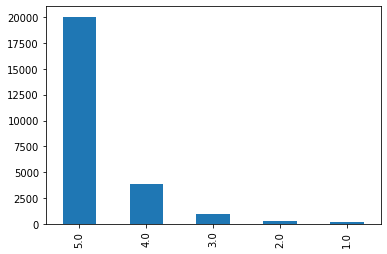

In [46]:
# Create a train dev split the same way we created the train test split (only single possible) ==> Fixed N
# Required as we used different splits for hyperparameter tuning for content based and collaborative filtering
# To compare the classification metrics, we have to use the same split
fixed_n_dev = 3
train_split, dev_split = get_fixedN_test_train_split(train_split, fixed_n_dev)
# Validate quality of train-dev split
print(f'Test size: {round((len(dev_split) / len(train_split)) * 100, 2)}% \n')
print('Rating distribution in test set \n')
get_rating_dist(dev_split.rating)

In [ ]:
# Define k for the number of Top recipes
k = 10

# Store the resuls of the different models
benchmark = []

# Get all recipes for which we need a recommendation
recipe_ids = list((set().union(train_split.recipe_id.unique(), dev_split.recipe_id.unique())))

# Filter only the recipes for which we need a recommendation
filtered_content_processed = content_processed.loc[content_processed['recipe_id'].isin(recipe_ids)]

# Recalculate tfidf-matrix for embeddings
content_tokenized = [content_item.split(" ") for content_item in filtered_content_processed["content"]]
tfidf_matrix = get_tfidf_wordembedding_matrix(content_tokenized, vocabulary_name_min)

# Calculate scores for content based models
content_based_models = {
    'Cosine SVD Model': get_cos_sim_matrix(filtered_content_processed, n_components_min, use_svd=True),
    'Cosine Plain Model': get_cos_sim_matrix(filtered_content_processed, n_components_min, use_svd=False),
    'Embedded Cosine Model': cosine_similarity(tfidf_matrix, tfidf_matrix),
    'Mixture Model': get_mix_sim_matrix(filtered_content_processed, lmbda_min, recipes_data)
}

for m_name, model in content_based_models.items():
    rec_dict = make_all_recommendations(dev_split.user_id.unique(), model, filtered_content_processed, train_split, k)

    # Compute metrics
    # Catalog coverage
    cat_cov = catalog_coverage(rec_dict, n_recipes)
    # Get hits per user (required for other metrics)
    n_hits_per_user = get_hits(rec_dict, dev_split)
    # Average precision
    precision = get_avg_precision(n_hits_per_user, k)
    # Average recall
    recall = get_avg_recall(n_hits_per_user, fixed_n_dev)
    # f1-score
    f_one = get_f_one(precision, recall)
    # Hitrate
    hitr = hitrate(n_hits_per_user)
    
    benchmark.append([m_name, cat_cov, precision, recall, f_one ,hitr])

In [53]:
# Prepare train and dev set for algos
# Create dataset objects from the train-test-split which is required for suprise package
trainset = Dataset.load_from_df(train_split[['user_id','recipe_id', 'rating']], Reader()).build_full_trainset()
devset = Dataset.load_from_df(dev_split[['user_id','recipe_id', 'rating']], Reader()).build_full_trainset().build_testset()

# Hard coded backup of best parameters
# algos = { 
#     'BaselineOnly': BaselineOnly(),
#     'KNNWithMeans': KNNBaseline(k=10, sim_options={'user_based': True, 'name': 'pearson'}),
#     'SVD': SVD(n_factors=10, lr_all=0.005, reg_all=0.04),
# }

for name, algo in algos.items():
    print(name)
    algo = algo(**results_cf_df.loc[name, 'BestParams'])
    print("Train Started")
    # Fit the algorithm on the train set
    algo.fit(trainset)
    print("Prediction Started")
    start = time.time()
    # Get predictions on dev set
    predictions = algo.test(devset)
    end = time.time()
    print(f'Runtime prediction of ratings in dev set: {round(end-start,2)}')
    # Get Top k recipes
    rec_dict = make_all_recommendations_cf(algo, trainset, 10, train_split, recipe_ids, k)
    # Catalog coverage
    cat_cov = catalog_coverage(rec_dict, n_recipes)
    # Get hits per user (required for other metrics)
    n_hits_per_user = get_hits(rec_dict, dev_split)
    # Average precision
    precision = get_avg_precision(n_hits_per_user, k)
    # Average recall
    recall = get_avg_recall(n_hits_per_user, fixed_n_dev)
    # f1-score
    f_one = get_f_one(precision, recall)
    # Hitrate
    hitr = hitrate(n_hits_per_user)
    
    benchmark.append([name, cat_cov, precision, recall, f_one, hitr])
    
benchmark_df = pd.DataFrame(benchmark, columns = ['Model', 'Catalog Coverage', 'Precision', 'Recall', 'f1' ,'Hitrate'])
benchmark_df.set_index('Model', inplace = True)
benchmark_df

BaselineOnly
Train Started
Estimating biases using als...
Prediction Started
Runtime prediction of ratings in dev set: 0.11
Estimate BaselineOnly
Runtime prediction of all ratings: 47.97
KNNWithMeans
Train Started
Computing the pearson similarity matrix...
Done computing similarity matrix.
Prediction Started
Runtime prediction of ratings in dev set: 2.88
Estimating biases using als...
Estimate KNNBaseline
Computing the pearson similarity matrix...
Done computing similarity matrix.
Runtime prediction of all ratings: 89.56
SVD
Train Started
Prediction Started
Runtime prediction of ratings in dev set: 0.19
Runtime prediction of all ratings: 49.01


,Catalog Coverage,Precision,Recall,f1,Hitrate
Model,,,,,
Cosine SVD Model,0.816700,0.000213,0.000712,0.000328,0.002135
Cosine Plain Model,0.743852,0.000154,0.000514,0.000237,0.001542
Embedded Cosine Model,0.671690,0.000142,0.000474,0.000219,0.001423
Mixture Model,0.738059,0.000202,0.000672,0.000310,0.002016
BaselineOnly,0.000638,0.001044,0.003479,0.001606,0.010438
BaselineOnly,0.000638,0.001044,0.003479,0.001606,0.010438
KNNWithMeans,0.600412,0.000676,0.002254,0.001040,0.006642
SVD,0.007216,0.000522,0.001740,0.000803,0.005219


<a id='final_scores'></a>
### 4.2 Final Scores

#### Helper functions 

In [85]:
def get_user_preference_cb_for_hybrid(user_id, similarity, content, interactions_data):
    """
    Returns
    ----------
    prediction_df:
        DataFrame in with columns ['recipe_id', 'prediction', 'has_rated'] for 1 user
    """
    #prepare similarity dataframe
    sim = pd.DataFrame(similarity, index = content['recipe_id'].values, columns = content['recipe_id'].values)
    #get already rated recipes of user
    rated_recipes = interactions_data.loc[interactions_data['user_id'] == user_id, 'recipe_id'].values
    #get similarities of ALL recipes w/ already rated recipes of user
    sim_rated_all = sim.loc[rated_recipes, :]
    #get ratings of already rated recipes
    ratings = get_reshaped_ratings(user_id, interactions_data)
    
    #compute weighted similarities between all recipes and already rated recipes
    weighted_sim = np.dot(ratings,sim_rated_all)
    #compute normalization constant
    norm_const = np.array(np.abs(sim_rated_all).sum(axis=0))
    #return sorted predictions
    pref_predictions = weighted_sim / norm_const
    
    flat_predictions = [item for sublist in pref_predictions for item in sublist]
    #return df with recipe id also
    prediction_df = pd.DataFrame(flat_predictions, index=content['recipe_id'].values, columns =['prediction'])
    #indicate the already tried recipes
    prediction_df['has_rated'] = prediction_df.index.isin(rated_recipes)
    #order predictions

    prediction_df['prediction'] = prediction_df.apply(lambda x: 0 if x.has_rated == True else x.prediction, axis=1)
    
    return prediction_df.prediction.to_numpy()

In [119]:
def make_all_recommendations_hm(cf_algos, cb_algos, algo_weighting, trainset, train_split, recipe_ids, content_processed, k):

    # Initialize empty dictionary for collaborative-filtering predictions
    est_cf = {}    
    # Make predictions for each collaborative-filting algorithm
    for name, algo in cf_algos.items():
        # Choose best parameters from hyperparameter tuning
        algo = algo(**results_cf_df.loc[name, 'BestParams'])
        # Fit the algorithm on the train set
        algo.fit(trainset)
        # Get predictions on dev set
        predictions = make_all_recommendations_cf(algo, trainset, 10, train_split, recipe_ids, k, return_est_ratings = True)
        # Weight predictions
        weight = algo_weighting.get(name)
        predictions.update((key, np.dot(weight, value)) for key, value in predictions.items())
        # Add weighted predictions
        est_cf = {key: est_cf.get(key, 0) + predictions.get(key, 0)
                  for key in set(predictions)}
        
    # Initialize empty dictionary for top-k predictions
    results = {}
    # Make predictions for content-based algorithms    
    for user, est_cf in est_cf.items():
        # Get weighting of the collaborative-filtering algorithms for the user
        est_all = est_cf
        # Make predictions for each content-based algorithm
        for name, algo in cb_algos.items():
            est_cb = get_user_preference_cb_for_hybrid(user, cb_algos.get(name), content_processed, train_split)
            weight = algo_weighting.get(name)
            est_all = est_all + np.dot(weight, est_cb)
        # Get the weighted average prediction of all algorithms
        est_all = est_all / sum(algo_weighting.values())
        # Get top-k predictions
        ratings_per_user = pd.DataFrame({'recipe_id': recipe_ids, 'rating': est_all})
        ratings_per_user.sort_values('rating', ascending=False, inplace=True)
        top_k_per_user = ratings_per_user.recipe_id.iloc[:k].to_numpy()
        results[user] = top_k_per_user
    return results

#### Scores

In [115]:
### Prepare for final computations
# Rebuild initial train test split as this might be overwritten over time
fixed_n_test = 3
train_split, test_split = get_fixedN_test_train_split(interactions, fixed_n_test)

# Build test and trainset for suprise package
trainset = Dataset.load_from_df(train_split[['user_id','recipe_id', 'rating']], Reader()).build_full_trainset()
testset = Dataset.load_from_df(test_split[['user_id','recipe_id', 'rating']], Reader()).build_full_trainset().build_testset()

# Set best weights
best_weights = {
    'KNNWithMeans': 0.5,
    'Cosine SVD Model': 0.5
}

# Specify models to be combined in the hybrid model
cf_algos = {
    'KNNWithMeans': KNNWithMeans
}

cb_algos = {
    'Cosine SVD Model': get_cos_sim_matrix(content_processed, 5, use_svd = True)
}


# Recipe ids we need recommendations for
recipe_ids = content_processed.recipe_id.to_numpy()

In [122]:
# Compute metrics for baseline

benchmark_final = []

# Fit
baseline_algo = BaselineOnly()
baseline_algo.fit(trainset)
# RMSE
predicitions_baseline = baseline_algo.test(testset)
rmse_baseline = accuracy.rmse(predicitions_baseline)
# Further Metrics
# Get Top k recipes
rec_dict_baseline = make_all_recommendations_cf(baseline_algo, trainset, 10, train_split, recipe_ids, k)
# Catalog coverage
cat_cov_baseline = catalog_coverage(rec_dict_baseline, n_recipes)
# Get hits per user (required for other metrics)
n_hits_per_user_baseline = get_hits(rec_dict_baseline, test_split)
# Average precision
precision_baseline = get_avg_precision(n_hits_per_user_baseline, k)
# Average recall
recall_baseline = get_avg_recall(n_hits_per_user_baseline, fixed_n_test)
# f1-score
f_one_baseline = get_f_one(precision_baseline, recall_baseline)
# Hitrate
hitr_baseline = hitrate(n_hits_per_user_baseline)

benchmark_final.append(['Baseline Only', rmse_baseline, cat_cov_baseline, 
                        precision_baseline, recall_baseline, f_one_baseline, hitr_baseline])

# Compute metrics for tuned hybrid model
print("Hybrid Started")

#RMSE
# Not reported for this model as it is it will be close to the baseline
rmse_hm = 0
# Further metrics
rec_dict_hm = make_all_recommendations_hm(cf_algos, cb_algos, best_weights, trainset, train_split, recipe_ids, content_processed, k)
# Catalog coverage
cat_cov_hm = catalog_coverage(rec_dict_hm, n_recipes)
# Get hits per user (required for other metrics)
n_hits_per_user_hm = get_hits(rec_dict_hm, test_split)
# Average precision
precision_hm = get_avg_precision(n_hits_per_user_hm, k)
# Average recall
recall_hm = get_avg_recall(n_hits_per_user_hm, fixed_n_test)
# f1-score
f_one_hm = get_f_one(precision_hm, recall_hm)
# Hitrate
hitr_hm = hitrate(n_hits_per_user_hm)

benchmark_final.append(['Hybrid Model', rmse_hm, cat_cov_hm, precision_hm, recall_hm, f_one_hm, hitr_hm])

Estimating biases using als...
RMSE: 0.6244
Estimate BaselineOnly
Runtime prediction of all ratings: 81.0
Hybrid Started
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimate KNN
Computing the pearson similarity matrix...
Done computing similarity matrix.
Runtime prediction of all ratings: 87.73


,TestRMSE,Catalog Coverage,Precision,Recall,f1,Hitrate
Model,,,,,,
Baseline Only,0.624371,0.000638,0.001127,0.003756,0.001734,0.011268
Baseline Only,0.624371,0.000638,0.001127,0.003756,0.001734,0.011268
Baseline Only,0.624371,0.000638,0.001127,0.003756,0.001734,0.011268
Hybrid Model,0.000000,0.621619,0.000166,0.000554,0.000255,0.001661


<a id='get_recommendations'></a>
### 4.3 Recommendations

In [76]:
# Insert date in string format of yyyy-mm-dd
def show_me_something_new(user_id, dateStr, recipes, k):
    """
     Returns
    ----------
    topk_recipes:
        array of top k recipe ids
    name:
        array with top k recipe names
    minutes:
        array with top k recipe duration in minutes
    submitted:
        array with top k recipe date of submission
    description:
        array with top k recipe descriptions
    recipeurl:
        array with top k urls to full recipe
    imageurl:
        array with top k urls to recipe image
    """
    # Transform date string in datetime format
    date = datetime.strptime(dateStr, '%Y-%m-%d')
    
    # Get all recipes that are no older than two weeks from today
    twoweeksago = date - timedelta(days=14)
    newRecipes = recipes[recipes['submitted'] > twoweeksago]
    
    # Order all recipes descending by avg_rating and num_interactions
    ordered_recipes = newRecipes.sort_values(by=['avg_rating', 'num_interactions'], ascending=False)
    #get top k recipe_id array of most rated and best rated recipes
    topk_recipes = ordered_recipes.index[:k].values

    imageurls = []
    recipeurls = []
    for entry in topk_recipes:
        recipeurls.append("https://www.food.com/recipe/" + str(entry))
#         imageurls.append(get_image_source_url(entry))

    info = recipes.loc[topk_recipes]
    info = info[['name', 'minutes', 'submitted', 'description']]
    info['recipeurl'] = recipeurls
#     info['imageurl'] = imageurls

    for index, row in info.iterrows():
        info.at[index, 'recipeurl'] = '<a href="'+ row['recipeurl'] + '">'+row['recipeurl'] +'</a>'
#         info.at[index, 'imageurl'] = '<a href="'+ row['imageurl'] + '"> Image of recipe '+str(index)+'</a>'
    info = HTML(info.to_html(escape=False))
    return(info)

In [82]:
def get_user_recommendations_demo(user_id, rec_dict, recipes_df):
    '''
    Function to get list of demoable recommendations
    
    @param user_id User Id of the user we want the recommendation for
    @param rec_dict Dict of users, where the keys are lists of recommendations
    @param recipes_df Dataframe of our recipes
    '''
    
    # If we know this user in our model get the recommendations from rec dict
    try:
        recommended_recipe_ids = rec_dict[user_id]
    except:
        return show_me_something_new(user_id, '2016-01-01', recipes_df, 10)
    
    imageurls = []
    recipeurls = []
    for entry in recommended_recipe_ids:
        recipeurls.append("https://www.food.com/recipe/" + str(entry))
#         imageurls.append(get_image_source_url(entry))

    info = recipes_df.set_index('recipe_id').loc[recommended_recipe_ids].reset_index(drop=False)
    info = info[['name', 'minutes', 'submitted', 'description']]
    info['recipeurl'] = recipeurls
#     info['imageurl'] = imageurls

    for index, row in info.iterrows():
        info.at[index, 'recipeurl'] = '<a href="'+ row['recipeurl'] + '">'+row['recipeurl'] +'</a>'
#         info.at[index, 'imageurl'] = '<a href="'+ row['imageurl'] + '"> Image of recipe '+str(index)+'</a>'
    info = HTML(info.to_html(escape=False))
    return(info)

In [134]:
### Get Recommendation for user 1533 with hybrid and baseline model
recommendations_9717_hm_df = get_user_recommendations_demo(9717, rec_dict_hm, recipes_data)

recommendations_9717_bl_df = get_user_recommendations_demo(9717, rec_dict_baseline, recipes_data)

In [135]:
recommendations_9717_hm_df

,name,minutes,submitted,description,recipeurl
0,ham cheddar crescents,20,2003-10-09,"i adopted this recipe in aug. 2006; it originally was posted by cbw. i love these, and dh loves to dip them in spicy mustard. cbw's original comments: ""found these in a pillsbury cookbook and have made them several times. my hubby and i really like these with a bowl of soup. simple, but really tasty!""",https://www.food.com/recipe/73011
1,cubano pork tenderloin,520,2006-04-06,this recipes produces a delicious pork tenderloin and i highly recommend using the optional rum. it makes a beautiful presentation on a platter garnished with orange slices. prep time is the time to marinate the tenderloins.,https://www.food.com/recipe/163154
2,gluten free gingersnap cookies,55,2006-06-20,"these are really delicious, this is the first gluten free recipe that i created myself! they taste exactly like wheat containing gingersnap cookies. these are regulars on my christmas cookie tray. when i first made them my family couldn't believe that they were gluten free.plus they freeze really well!",https://www.food.com/recipe/174115
3,citrus loaf,55,2008-03-25,"this is a nice and refreshing quick bread loaf. it is perfect for gift giving or enjoying with your afternoon tea, and it freezes well too. it is one of my top sellers at our local farmer's market. give it a try...i'm sure you will enjoy it.",https://www.food.com/recipe/294374
4,granny s banana cream pie,49,2002-06-10,so delicious !!,https://www.food.com/recipe/30946
5,oatmeal muffins no flour at all,25,2005-01-17,you can use bananas instead of the nuts and raisins,https://www.food.com/recipe/108564
6,easy delicious ham and dijon sandwiches,22,2005-01-20,"recipe from steve erehart's mom, served at a football party... couldn't get the taste out of my mind for days! had to call and ask how!",https://www.food.com/recipe/108947
7,5 minute mug chocolate cake,5,2008-09-19,"made in a coffee mug that you cook in the microwave! i got this from my nextdoor neighboor who found it on an internet forward. its delicous! it can be a little dry, try topping or swirling with chocolate syrup?",https://www.food.com/recipe/325674
8,cookie icing frosting that hardens,10,2007-11-19,"this will harden and it will hardens quite quickly, it's the perfect icing to decorate cookies, if desired you may omit the vanilla, i like to add it in, the amounts may be reduced by half if desired.",https://www.food.com/recipe/266529
9,double coconut cake with fluffy coconut frosting,75,2002-01-05,"special occasion cake, great birthday cake! edited from cooking light.",https://www.food.com/recipe/16773


In [136]:
recommendations_9717_bl_df

,name,minutes,submitted,description,recipeurl
0,black bean and corn salad dip,15,2003-07-07,"refreshing! light! great way to use that last cob of grilled corn. gives the dish a light smokey flavor. good for picnics, camping,& pot luck. makes a good side as well as a meal. using it as a relish to top grilled salmon or tuna. try dipping tortilla chips into it.",https://www.food.com/recipe/66294
1,the original rice krispies treats squares,10,2004-07-21,"this is the recipe for the original rice krispies treats squares...it never fails! plus, it is a great way to use up a box of cereal! for best results, use fresh marshmallows. i have replaced the butter once with mott's healthy baking butter or oil substitute (it was basically an unsweetened apple sauce) and they still turned out great!",https://www.food.com/recipe/96111
2,chicken tortilla soup ii,70,1999-11-17,"i'm getting tired of seeing the so-called tortilla soup recipes running around that are nothing but a glorified chicken soup with tortillas added. here's the real mccoy. similar to the recipe at houston's restaurant (modified, of course, to suit my tastes)\r\n\r\nfor a beef version check out my recipe #261711.",https://www.food.com/recipe/4627
3,blueberry sour cream pie,45,2003-01-14,,https://www.food.com/recipe/51257
4,good eats roast turkey,920,2001-07-04,"from alton brown's show. brining the bird is the key to moist meat. made this again this year, only brined in just water instead of stock to save some dough. again, the bird turned out perfect. growing up, i hated white meat because it was always dry and grinding on your teeth ;-), now i love white meat. cook time includes the brining time.",https://www.food.com/recipe/9954
5,simple tomato sandwich,5,2004-08-27,"i am only posting such a simple recipe because i actually somehow lived 29 years of life before my husband introduced me to the tomato sandwich. if you've only used tomatoes as an accessory in your sandwiches, and not as the featured ingredient, you are truly missing summer as it was meant to be tasted. note: after many years, i have solidly converted to mayo for this sandwich, with fresh ground black pepper too. (oct 2012)",https://www.food.com/recipe/98724
6,bacon wrapped jalapeno poppers,20,2004-12-08,these bacon-wrapped jalapeno poppers are unbelievably good! you'll love them!,https://www.food.com/recipe/105670
7,nutella hot chocolate,6,2003-10-28,"this is too easy, and is an almost nightly ritual in my house. i've based the measurements on a recipe from another site, but that one calls for water to thin the nutella. i've never tried it that way. the cooking time is approximate.",https://www.food.com/recipe/74086
8,cream cheese delight,42,2005-11-19,"this recipe came from one of my clients, when i dropped over on a chilly winter morning, and i smelled it throughout her lovely home. yum!",https://www.food.com/recipe/145573
9,my best zucchini bread,90,2002-03-02,this makes 2 loaves of the best zucchini bread i have ever tasted.,https://www.food.com/recipe/21171
